### Approach


<div style="background-color: #ccffcc; color: black; padding: 10px;">
<p>

**State variables** 
1. Coach tickets available $c_i$
2. First tickets available $f_i$
3. day from flight listing $t$

**Choices**
1. Price of coach class ticket $P_c$ - high $H_c$ or low $L_c$ 
2. Price of first class ticket $P_f$ - high $H_f$ or low $L_f$

**Value function**
$$ V(c, f, t) = \sum (profit @ t + i) * \delta^i for \space i \in [0, T-t] $$

where $\delta$ is the discounting factor for net present value

At the day of the flight, $T$, there will not be any more flight booking hence revenue will be zero, hence profit will be composed on cost due to class upgrade or kicking the passengers from the flight
$$ V(c, f, T) = - E[cost \space if \space sold \space c \space coach \space tickets \space and \space f \space first \space class \space tickets] $$

Expected cost at the day of flight can be written as below - 
$$E[cost  for \space c \space coach \space tickets \space and \space f \space first \space class \space tickets]  = $$
$$\sum_{i = 0}^{c}\mathop{}_{\mkern-5mu} \sum_{j = 0}^{f}\mathop{}_{\mkern-5mu} p(i|c) * p(j|f) * overbooking \space cost \space to \space accomodate \space i \space in \space coach \space and \space f  \space in \space first class $$

**Bellman equation**
$$ V(c, f, t) = {max}\mathop{}_{p} E[revenue @ t | p] + E[V(c^{'}, f^{'}, t+1) | p]$$
$$ where \space p \in {(H_c,H_f), (H_c,L_f), (L_c,H_f), (L_c,L_f)} $$

Both revenue and value function for each state will depend on the price choice $p$. There are four possible outcome for any price choice $p$ - 
1. ticket sale for both classes
2. ticket sale for coach but not sale for first, 
3. ticket sale for first class but not coach
4. no sale for both classes

Expected revenue & value function at $t$ will be as below - 

$$ E[revenue | p] = (c_i + f_i) * p(coach sale) * p(first sale) + $$

$$ c_i * p(coach sale) * p(no first sale) + $$

$$ f_i * p(no coach sale) * p(first sale) + $$

$$ 0 * p(no coach sale) * p(no first sale)$$

$$ E[value function | p] = V(c-1, f-1, t+1) * p(coach sale) * p(first sale) + $$

$$ V(c-1, f, t+1) * p(coach sale) * p(no first sale) + $$

$$ V(c, f-1, t+1) * p(no coach sale) * p(first sale) + $$

$$ V(c, f, t+1) * p(no coach sale) * p(no first sale) $$

**Boundary condition**

- T=365 days
    - V(c,f,T) = Revenue@T - E[Overbooking costs@T]
    - V(c,f,T) = - E[Overbooking costs@T]
    
    
</div>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re, seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from scipy.stats import norm
import scipy
%matplotlib inline

### Defining Parameters

<div style="background-color: #ffe5e5; color: black; padding: 10px;">
<p>

- capacity: capacity of the flight in each of the ticket classes - coach and first-class  
- extra: over-booking policy in each of the ticket classes. 
- 'ctof' is cost of upgrading a customer from coach to first-class. 
- 'ctoout' is cost of bumping a customer off the plane.
    
</p>
</div>

<div style="background-color: #ffe5e5; color: black; padding: 10px;">
<p>

**Details on ticket sales and passenger attendance probabilities**

- Likelihood of selling a ticket and the chance of a passenger arriving for their flight as specified in the scenario.
- Revenue generated from selling a seat in both coach and first class, considering varying pricing strategies for the day.</p>
    
</div>

**Global**

In [3]:
extra = {'coach':5,'first-class':0} #Number of seats overbooked in Coach


costs = {'ctof':50, 'ctoout':425} #Cost of upgrading a Coach ticket to First-Class
                                    #Cost to airlines to cancell a ticket

#****Discount-rate Options for both the ticket classes***
delta = 1/(1+0.17/365)

T = 365 #days until takeoff

**Coach and First-Class**

In [4]:
capacity = {'coach':100,'first-class':20} 

#****Low-High Price***
price = {'coach':[300,350],'first-class':[425,500]} 

##****Probabilities of sale***
prob = {'coach':[0.65,0.3],'first-class':[0.08,0.04]} 




### Value and Decision Matrices

<div style="background-color: #ffe5e5; color: black; padding: 10px;">
<p>
This function(ticket_price_optimizer) utilizes the previously defined variables to generate Value and Decision matrices. These matrices are instrumental in calculating the expected profit and determining the optimal decisions for various situations.</p>
</div>

In [5]:
def tickets_price_optimizer(capacity,extra,costs,price,prob,delta,T):
    
    Sc_left_Values = np.arange(capacity['coach']+extra['coach']+1) #all possibleseats left in coach
    Sf_left_Values = np.arange(capacity['first-class']+extra['first-class']+1) #all possible seats left in first-class
    tValues_days = np.arange(T+1) #all possible days until takeoff
    
    ScN = len(Sc_left_Values)
    SfN = len(Sf_left_Values)
    tN = len(tValues_days)
    
    # initialize value function
    V = np.zeros((ScN,tN,SfN)) 
    
    # initialize optimal choice variable
    U = np.zeros((ScN,tN,SfN)) 
    
    #*****Low and High Prices*****
    priceLc = price['coach'][0] 
    priceHc = price['coach'][1]  
    priceLf = price['first-class'][0] 
    priceHf = price['first-class'][1] 

    #*****Demand Probabilities****
    prob_Lc = [1-prob['coach'][0],prob['coach'][0]] 
    prob_Hc = [1-prob['coach'][1],prob['coach'][1]] 
    prob_Lf = [1-prob['first-class'][0],prob['first-class'][0]] 
    prob_Hf = [1-prob['first-class'][1],prob['first-class'][1]]
    
    #****Capacity******
    Cc = capacity['coach'] #capacity of coach
    Cf = capacity['first-class'] #capacity of first-class

    #***Boundary/Terminal condition*****
    # 3 is the value for no tickets for sale 
    #Ten's digit represents the optimal decision for coach tickets and the units digit represents the optimal decision for first-class tickets. 
    # 1: lower price
    # 2: higher price
    U[:,tN-1,:] = 33 
    
    
    #****Cost Calculations-Loop:number of seats available******
    for Sc in range(ScN):
        tc_booked = ScN - Sc-1 # number of tickets booked
        
        for Sf in range(SfN):
            tf_booked = SfN - Sf-1 # number of first-class tickets booked
            cost = 0
            
            #Iterating over each possible number of coach passengers actually showing up on the day of departure
            for tc_act_show in range(tc_booked+1): 
                # probability of 'tc_act_show'/'tc_booked' number of people showing up
                prob_tc_act_show = scipy.stats.binom.pmf(tc_act_show,tc_booked,0.95)
                
                
                #**** Iterating over each possible number of First-Class passengers Actually**** 
                for tf_act_show in range(tf_booked+1): 
                #showing up on the day of departure
                #probability of 'tf_act'/ 'tf number of people showing up 
                    prob_tf_act_show = scipy.stats.binom.pmf(tf_act_show,tf_booked,0.97)
                    
                    if tc_act_show<=Cc: 
                        cost = cost+0 #no cost
                    else:
                        # capacity of the coach < number of coach passengers who showed up< number of seats remaining in first-class 
                        if tc_act_show-Cc <= Cf-tf_act_show:
                        # cost associated with bumping all of them to first-class
                            cost = cost - prob_tc_act_show*prob_tf_act_show*costs['ctof']*(tc_act_show-Cc)
                        
                        else:
                        #number of coach passengers who showed up >  capacity of the coach 
                        #and number of coach passengers who showed up > number of seats remaining in first-class
                        #cost linked to transferring some coach passengers to first-class and removing the remaining passengers from the plane
                            cost = cost - prob_tc_act_show*prob_tf_act_show*(costs['ctof']*(Cf-tf_act_show) 
                                                               + costs['ctoout']*(tc_act_show-Cc-(Cf-tf_act_show)))
            V[Sc,tN-1,Sf] = cost
        
    
    #*****Bellman Equation*****
    #Calculate the optimal price and optimal choice
    for t in reversed(range(tN-1)):
        for Sc in range(ScN):
            for Sf in range(SfN):
                
                #Fully booked scenario: you can't make money and no tickets can be sold
                if Sc==0 and Sf==0: 
                    V[Sc,t,Sf]= delta * V[Sc,t+1,Sf] 
                    U[Sc,t,Sf]=33

                elif Sc !=0 and Sf==0: # There are coach tickets available but not first-class. This increases the 
                    # probability of sale coach tickets by 0.03.
                    
                    # Value when set coach ticket price low
                    value_Lc = (prob_Lc[1]+0.03)*priceLc + delta* ((prob_Lc[0]-0.03)*V[Sc,t+1,Sf] + (prob_Lc[1]+0.03)*V[Sc-1,t+1,Sf])
                    
                    # Value when set coach ticket price high
                    value_Hc = (prob_Hc[1]+0.03)*priceHc + delta* ((prob_Hc[0]-0.03)*V[Sc,t+1,Sf] + (prob_Hc[1]+0.03)*V[Sc-1,t+1,Sf]) 

                    V[Sc,t,Sf]=max(value_Lc,value_Hc) # value function maximizes expected profit
                    U[Sc,t,Sf]=(np.argmax([value_Lc,value_Hc])+1)*10+3
                
                #First-class tickets available but not coach
                elif Sc == 0 and Sf!=0: 
                    
                    # Value when set the first-class ticket price low
                    value_Lf = (prob_Lf[1])*priceLf + delta* ((prob_Lf[0])*V[Sc,t+1,Sf] + (prob_Lf[1])*V[Sc,t+1,Sf-1])
                    
                    # Value when set the first-class ticket price high
                    value_Hf = (prob_Hf[1])*priceHf + delta* ((prob_Hf[0])*V[Sc,t+1,Sf] + (prob_Hf[1])*V[Sc,t+1,Sf-1]) 

                    V[Sc,t,Sf]=max(value_Lf,value_Hf) 
                    U[Sc,t,Sf]=30+np.argmax([value_Lf,value_Hf])+1

                else:
                    # Value when set both coach and first-class ticket prices low
                    value_LL = prob_Lc[1]*priceLc + prob_Lf[1]*priceLf + delta* (prob_Lf[0]*prob_Lc[0]*V[Sc,t+1,Sf]
                                                                        +prob_Lf[0]*prob_Lc[1]*V[Sc-1,t+1,Sf]
                                                                        +prob_Lf[1]*prob_Lc[1]*V[Sc-1,t+1,Sf-1]
                                                                        +prob_Lf[1]*prob_Lc[0]*V[Sc,t+1,Sf-1])

                    # value when set coach ticket price low and first-class ticket price high
                    value_LH = prob_Lc[1]*priceLc + prob_Hf[1]*priceHf + delta* (prob_Hf[0]*prob_Lc[0]*V[Sc,t+1,Sf]
                                                                        +prob_Hf[0]*prob_Lc[1]*V[Sc-1,t+1,Sf]
                                                                        +prob_Hf[1]*prob_Lc[1]*V[Sc-1,t+1,Sf-1]
                                                                        +prob_Hf[1]*prob_Lc[0]*V[Sc,t+1,Sf-1])

                    # value when set coach ticket price high and first-class ticket price low
                    value_HL = prob_Hc[1]*priceHc + prob_Lf[1]*priceLf + delta* (prob_Lf[0]*prob_Hc[0]*V[Sc,t+1,Sf]
                                                                        +prob_Lf[0]*prob_Hc[1]*V[Sc-1,t+1,Sf]
                                                                        +prob_Lf[1]*prob_Hc[1]*V[Sc-1,t+1,Sf-1]
                                                                        +prob_Lf[1]*prob_Hc[0]*V[Sc,t+1,Sf-1])

                    # value when set both coach and first-class ticket prices high
                    value_HH = prob_Hc[1]*priceHc + prob_Hf[1]*priceHf + delta* (prob_Hf[0]*prob_Hc[0]*V[Sc,t+1,Sf]
                                                                        +prob_Hf[0]*prob_Hc[1]*V[Sc-1,t+1,Sf]
                                                                        +prob_Hf[1]*prob_Hc[1]*V[Sc-1,t+1,Sf-1]
                                                                        +prob_Hf[1]*prob_Hc[0]*V[Sc,t+1,Sf-1])


                    V[Sc,t,Sf]=max(value_LL,value_LH,value_HL,value_HH) # value funciton maximizes expected profit 

                    U[Sc,t,Sf]=(int(np.argmax([value_LL,value_LH,value_HL,value_HH])/2)+1)*10\
                    +int((np.argmax([value_LL,value_LH,value_HL,value_HH])%2)!=0)+1
    return U,V

# Strategy 1-Expected profit when we decide to have overbooking of 5 coach seats 

<div style="background-color: #ccffcc; color: black; padding: 10px;">
<p>

**Simplifying the Price and Probability Equation**

The expected revenue, **Price**, from selling tickets can be broken down into four scenarios based on the probabilities of selling coach and first-class tickets.Let's denote **A** as the price of a coach ticket and **B** as the price of a first-class ticket.

- Price: We get A if the ticket sold in a coach and 0 if the ticket doesnot.
- For the above scenario i.e the coach Probability will be x and x-1 respectively.
- Price: We get B if the ticket sold in a first class and 0 if the ticket doesnot.
- For the above scenario i.e. the first-class Probability will be y and y-1 respectively.


**4 Scenarios:**
- Both coach and first-class tickets are sold: expected value- xy(A+B)
- Only the coach ticket is sold: expected value- x(1-y)A
- Only the first-class ticket is sold: expected value- (1-x)yB
- Neither ticket is sold: expected value- (1-x)(1-y)0


**E[Price] = xy(A+B) + x(1-y)A + (1-x)yB + (1-x)(1-y)0 = xA+yB+delta(...)**
    </p>
</div>

### Overbooking 5 Coach Tickets

In [17]:
U_5,V_5 = tickets_price_optimizer(capacity,extra,costs,price,prob,delta,T) # running the function for the policy of 


### Expected Profit

In [18]:
print(f'Expected Profit: $ {round(V_5[105,0,20],5)}')

Expected Profit: $ 41886.15862


In [20]:
z,x,y = U_5.nonzero()

### Visualization of Booking Strategy

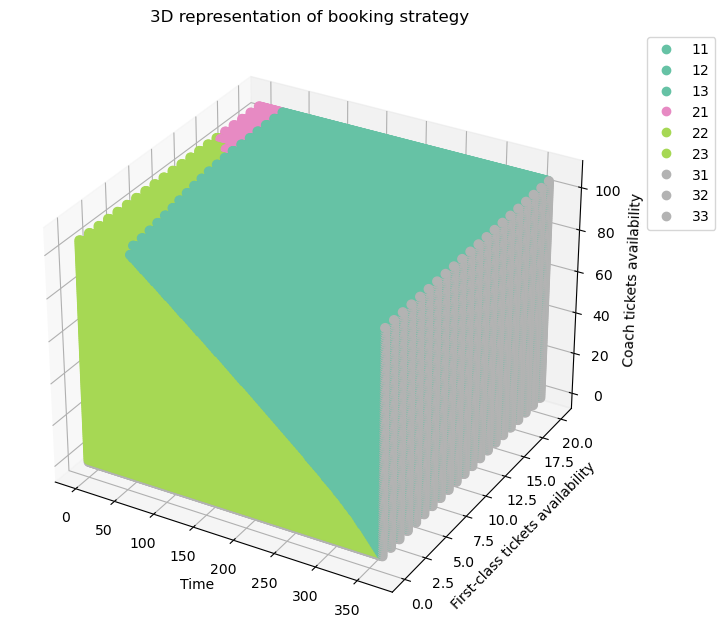

In [21]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

cmap = ListedColormap(sns.color_palette('Set2', 8).as_hex())


sc = ax.scatter(x, y, z, s=40, c=U_5[z,x,y], marker='o', cmap=cmap, alpha=1)
ax.set_xlabel('Time')
ax.set_ylabel('First-class tickets availability')
ax.set_zlabel('Coach tickets availability')


plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

plt.title('3D representation of booking strategy')
plt.show()

### At Random Times : Booking Strategy

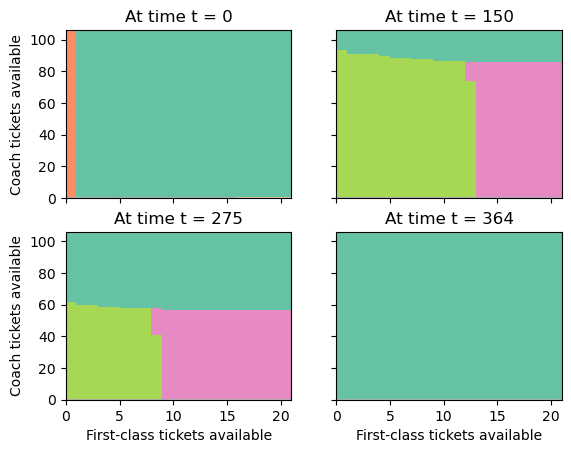

In [22]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].pcolor(U_5[:,0,:] , cmap = cmap);
axs[0, 0].set_title('At time t = 0')
axs[0, 1].pcolor(U_5[:,100,:] , cmap = cmap);
axs[0, 1].set_title('At time t = 150')
axs[1, 0].pcolor(U_5[:,200,:] , cmap = cmap);
axs[1, 0].set_title('At time t = 275')
axs[1, 1].pcolor(U_5[:,364,:] , cmap = cmap);
axs[1, 1].set_title('At time t = 364')

for ax in axs.flat:
    ax.set(xlabel='First-class tickets available', ylabel='Coach tickets available')

for ax in axs.flat:
    ax.label_outer()
plt.show()

### Booking Strategy
- 11: Both the tickets are priced low
- 12: Coach is priced low and first-class is priced high
- 13: Coach is priced low and first-class is unavailable
- 21: Coach is priced high and first-class is priced low
- 22: Both the tickets are priced high
- 23: Coach is priced high and first-class is unavailable
- 31: Coach is unavailable and first-class is priced low
- 32: Coach is unavailable and first-class is priced high
- 33: Both the tickets are unavailable

# 2-Expected profits for overbooking 5-15 coach tickets

In [23]:
extra_6_15 = [i for i in range(5,16)]
expected_profit = {}
for e in extra_5_15:
    extra = {'coach':e,'first-class':0}
    U,V = tickets_price_optimizer(capacity,extra,costs,price,prob,delta,T)
    expected_profit[e] = V[capacity['coach']+extra['coach'],0,capacity['first-class']+extra['first-class']]
    
    
    

In [27]:
expected_profit_df = pd.DataFrame(list(expected_profit.items()), columns=['Number of Overbook Coach Seats', 'Expected Profit'])
expected_profit_df

,Number of Overbook Coach Seats,Expected Profit
0,5,41886.158624
1,6,42011.221060
2,7,42085.536156
3,8,42122.167269
4,9,42134.624830
5,10,42132.900382
6,11,42123.665936
7,12,42111.029670
8,13,42097.419510
9,14,42084.111570


**Most profitable to overbook: 9 seats with $42134.624830** in profit

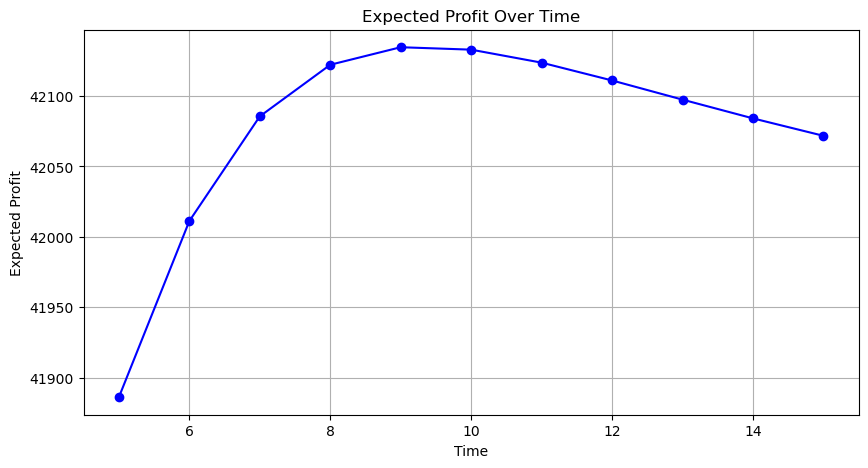

In [30]:
import matplotlib.pyplot as plt


times = list(expected_profit.keys())
profits = list(expected_profit.values())


plt.figure(figsize=(10, 5))
plt.plot(times, profits, marker='o', linestyle='-', color='blue',label='Expected Profit')
plt.title('Expected Profit Over Time')
plt.xlabel('Time')
plt.ylabel('Expected Profit')
plt.grid(True)
plt.show()


# Strategy 2- Adding the choice of not selling coach tickets despite having them available

In [50]:
def modified_tickets_price_optimizer(capacity,extra,costs,price,prob,delta,T):
    
    Sc_left_Values = np.arange(capacity['coach']+extra['coach']+1) 
    Sf_left_Values = np.arange(capacity['first-class']+extra['first-class']+1) 
    tValues_days = np.arange(T+1) 
    ScN = len(Sc_left_Values)
    SfN = len(Sf_left_Values)
    tN = len(tValues_days)
    
   
    V = np.zeros((ScN,tN,SfN)) 
    
    
    U = np.zeros((ScN,tN,SfN)) 
    
    #*****Prices*****
    priceLc = price['coach'][0] 
    priceHc = price['coach'][1]  
    priceLf = price['first-class'][0] 
    priceHf = price['first-class'][1] 

    #*****Probabilities****
    prob_Lc = [1-prob['coach'][0],prob['coach'][0]] 
    prob_Hc = [1-prob['coach'][1],prob['coach'][1]] 
    prob_Lf = [1-prob['first-class'][0],prob['first-class'][0]] 
    prob_Hf = [1-prob['first-class'][1],prob['first-class'][1]] 
    
    #****Capacity******
    Cc = capacity['coach'] 
    Cf = capacity['first-class'] 

    #***Boundary/Terminal condition*****
    U[:,tN-1,:] = 33
    
    
    #****Cost Calculations-Iterations******
    for Sc in range(ScN):
        tc_booked = ScN - Sc-1 
        
        for Sf in range(SfN):
            tf_booked = SfN - Sf-1 
            cost = 0
            
            for tc_act_show in range(tc_booked+1): 
                prob_tc_act_show = scipy.stats.binom.pmf(tc_act_show,tc_booked,0.95)  
                                                                                     
                
                
                #**** Looping over each possible number of First-Class passengers Actually**** 
                for tf_act_show in range(tf_booked+1): 

                    prob_tf_act_show = scipy.stats.binom.pmf(tf_act_show,tf_booked,0.97)
              
                    if tc_act_show<=Cc: 
                        cost = cost+0
                    else:
                        if tc_act_show-Cc <= Cf-tf_act_show:
                            cost = cost - prob_tc_act_show*prob_tf_act_show*costs['ctof']*(tc_act_show-Cc)
                        else:
                            cost = cost - prob_tc_act_show*prob_tf_act_show*(costs['ctof']*(Cf-tf_act_show) 
                                                               + costs['ctoout']*(tc_act_show-Cc-(Cf-tf_act_show)))
            V[Sc,tN-1,Sf] = cost
        
    
    #*****Bellman Equation
    for t in reversed(range(tN-1)):
        for Sc in range(ScN):
            for Sf in range(SfN):

                if Sc==0 and Sf==0: 
                    V[Sc,t,Sf]= delta * V[Sc,t+1,Sf] 
                    U[Sc,t,Sf]=33 

                elif Sc !=0 and Sf==0: 
                    
                    # Value when set the coach ticket price low
                    value_Lc = (prob_Lc[1]+0.03)*priceLc + delta * ((prob_Lc[0]-0.03)*V[Sc,t+1,Sf] + (prob_Lc[1]+0.03)*V[Sc-1,t+1,Sf])
                    
                    # Value when set the coach ticket price high
                    value_Hc = (prob_Hc[1]+0.03)*priceHc + delta * ((prob_Hc[0]-0.03)*V[Sc,t+1,Sf] + (prob_Hc[1]+0.03)*V[Sc-1,t+1,Sf])
                    
                    # value when decide not to sell the coach ticket
                    value_0c = 0 + delta * V[Sc,t+1,Sf] 

                    V[Sc,t,Sf]=max(value_Lc,value_Hc,value_0c) # value function maximizes expected profit
                    U[Sc,t,Sf]=(np.argmax([value_Lc,value_Hc,value_0c])+1)*10+3

                elif Sc == 0 and Sf!=0: 
                    
                    # value when the first-class ticket price low
                    value_Lf = (prob_Lf[1])*priceLf + delta * ((prob_Lf[0])*V[Sc,t+1,Sf] + (prob_Lf[1])*V[Sc,t+1,Sf-1])
                    
                    # value when the first-class ticket price high
                    value_Hf = (prob_Hf[1])*priceHf + delta * ((prob_Hf[0])*V[Sc,t+1,Sf] + (prob_Hf[1])*V[Sc,t+1,Sf-1]) 

                    V[Sc,t,Sf]=max(value_Lf,value_Hf) 
                    U[Sc,t,Sf]=30+np.argmax([value_Lf,value_Hf])+1

                else:
                    # value when decide not to sell coach and set first-class ticket price low
                    value_0L = prob_Lf[1]*priceLf + delta * (prob_Lf[0]*V[Sc,t+1,Sf]+prob_Lf[1]*V[Sc,t+1,Sf-1])

                    # value when decide not to sell coach and set first-class ticket price high
                    value_0H = prob_Hf[1]*priceHf + delta * (prob_Hf[0]*V[Sc,t+1,Sf]+prob_Hf[1]*V[Sc,t+1,Sf-1])
                    
                    # value when both coach and first-class ticket prices low
                    value_LL = prob_Lc[1]*priceLc + prob_Lf[1]*priceLf + delta * (prob_Lf[0]*prob_Lc[0]*V[Sc,t+1,Sf]
                                                                        +prob_Lf[0]*prob_Lc[1]*V[Sc-1,t+1,Sf]
                                                                        +prob_Lf[1]*prob_Lc[1]*V[Sc-1,t+1,Sf-1]
                                                                        +prob_Lf[1]*prob_Lc[0]*V[Sc,t+1,Sf-1])

                    # value when set coach ticket price low and first-class ticket price high
                    value_LH = prob_Lc[1]*priceLc + prob_Hf[1]*priceHf + delta * (prob_Hf[0]*prob_Lc[0]*V[Sc,t+1,Sf]
                                                                        +prob_Hf[0]*prob_Lc[1]*V[Sc-1,t+1,Sf]
                                                                        +prob_Hf[1]*prob_Lc[1]*V[Sc-1,t+1,Sf-1]
                                                                        +prob_Hf[1]*prob_Lc[0]*V[Sc,t+1,Sf-1])

                    # value when set coach ticket price high and first-class ticket price low
                    value_HL = prob_Hc[1]*priceHc + prob_Lf[1]*priceLf + delta * (prob_Lf[0]*prob_Hc[0]*V[Sc,t+1,Sf]
                                                                        +prob_Lf[0]*prob_Hc[1]*V[Sc-1,t+1,Sf]
                                                                        +prob_Lf[1]*prob_Hc[1]*V[Sc-1,t+1,Sf-1]
                                                                        +prob_Lf[1]*prob_Hc[0]*V[Sc,t+1,Sf-1])

                    # value when set both coach and first-class ticket prices high
                    value_HH = prob_Hc[1]*priceHc + prob_Hf[1]*priceHf + delta * (prob_Hf[0]*prob_Hc[0]*V[Sc,t+1,Sf]
                                                                        +prob_Hf[0]*prob_Hc[1]*V[Sc-1,t+1,Sf]
                                                                        +prob_Hf[1]*prob_Hc[1]*V[Sc-1,t+1,Sf-1]
                                                                        +prob_Hf[1]*prob_Hc[0]*V[Sc,t+1,Sf-1])


                    V[Sc,t,Sf]=max(value_LL,value_LH,value_HL,value_HH,value_0L,value_0H) # value funciton maximizes expected profit 

                    U[Sc,t,Sf]=(int(np.argmax([value_LL,value_LH,value_HL,value_HH,value_0L,value_0H])/2)+1)*10\
                    +int((np.argmax([value_LL,value_LH,value_HL,value_HH,value_0L,value_0H])%2)!=0)+1
    return U,V

In [51]:
extra_modified = {'coach':20,'first-class':0}
U_modified,V_modified = modified_tickets_price_optimizer(capacity,extra_modified,costs,price,prob,delta,T)

In [52]:
V_modified[120,0,20]

42139.892762319796

# 3-Estimating expected profits for overbooking 5-20 coach tickets

In [53]:
extra_5_20_modified = [i for i in range(5,21)]
expected_profit_modified = {}
for e in extra_5_20_modified:
    extra_modified = {'coach':e,'first-class':0}
    U_modified,V_modified = modified_tickets_price_optimizer(capacity,extra_modified,costs,price,prob,delta,T)
    expected_profit_modified[e] = V_modified[capacity['coach']+extra_modified['coach'],0,capacity['first-class']+extra_modified['first-class']]

In [56]:
expected_profit_modified_df = pd.DataFrame(list(expected_profit_modified.items()), columns=['Number of Overbook Coach Seats', 'Expected Profit'])
expected_profit_modified_df

,Number of Overbook Coach Seats,Expected Profit
0,5,41886.158624
1,6,42011.221060
2,7,42085.536156
3,8,42122.167269
4,9,42134.624830
5,10,42138.140498
6,11,42139.327940
7,12,42139.708945
8,13,42139.831425
9,14,42139.872225


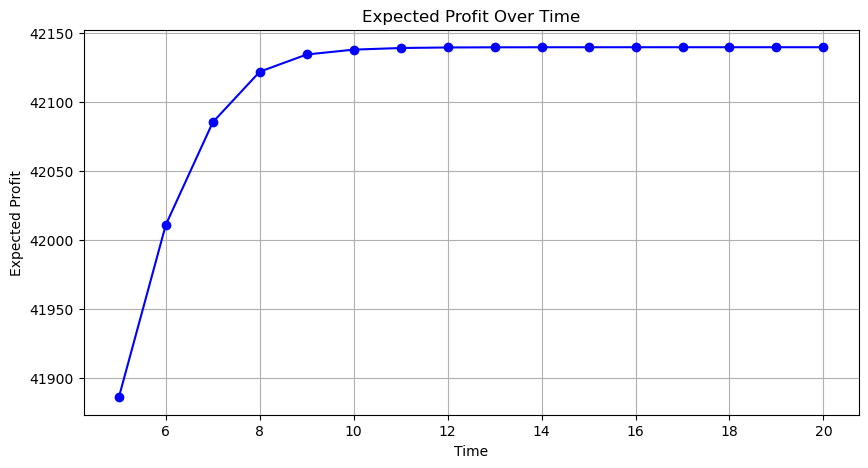

In [57]:
times = list(expected_profit_modified.keys())
profits = list(expected_profit_modified.values())

plt.figure(figsize=(10, 5))
plt.plot(times, profits, marker='o', linestyle='-', color='blue')
plt.title('Expected Profit Over Time')
plt.xlabel('Time')
plt.ylabel('Expected Profit')
plt.grid(True)
plt.show()


### Optimal overbooking strategy without the option of not selling coach tickets despite them being available

In [58]:
extra = {'coach':9,'first-class':0}
U_optimal,V_optimal = tickets_price_optimizer(capacity,extra,costs,price,prob,delta,T)

In [59]:
V_optimal[109,0,20]

42134.62483034169

We can see here that after 15 tickets, we are not getting any more profit at the nearest cent. With
this strategy, we are getting $42139.89 in expected profit.



### Comparison of Strategies

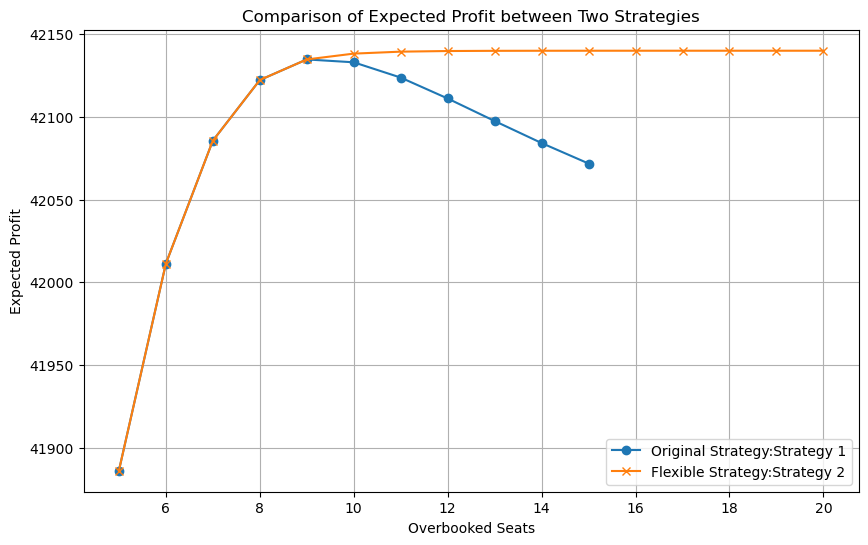

In [64]:
import matplotlib.pyplot as plt
import pandas as pd


expected_profit_df = pd.DataFrame(list(expected_profit.items()), columns=['Extra Coach Seats', 'Expected Profit (Strategy 1)'])
expected_profit_modified_df = pd.DataFrame(list(expected_profit_modified.items()), columns=['Extra Coach Seats', 'Expected Profit (Strategy 2)'])

comparison_df = pd.merge(expected_profit_df, expected_profit_modified_df, on='Extra Coach Seats', how='outer')

# Plotting the comparison
plt.figure(figsize=(10, 6))
plt.plot(comparison_df['Extra Coach Seats'], comparison_df['Expected Profit (Strategy 1)'], label='Original Strategy:Strategy 1', marker='o')
plt.plot(comparison_df['Extra Coach Seats'], comparison_df['Expected Profit (Strategy 2)'], label='Flexible Strategy:Strategy 2', marker='x')
plt.xlabel('Overbooked Seats')
plt.ylabel('Expected Profit')
plt.title('Comparison of Expected Profit between Two Strategies')
plt.legend()
plt.grid(True)
plt.show()


- In the analysis of two distinct strategies for ticket sales optimization, the results indicate a nuanced difference in performance between the two approaches. With Strategy 1, the expected profit stands at $42,134.62

- In contrast, Strategy 2  yields a slightly higher expected profit of $42,139.89, marking an incremental increase of 5.27 dollars. This marginal improvement in profits under Strategy 2, albeit small, suggests its superior efficacy over Strategy 1.

# Simulation: Analyze the overbooking strategies

<div style="background-color: #ffe5e5; color: black; padding: 10px;">
<p>
This function calculates the expected profit based on the number of additional seats that have been overbooked. It also provides the total bookings for coach and first-class tickets, as well as the actual number of passengers in each class who are present at the time of departure.</p>
    
</div>

In [65]:
def profit_simulation(U,V,extra):
    Sc = 100 + extra # all seats (capacity+extra) are available in coach - 1st day
    Sf = 20 # all seats are available in first-class - 1st day
    
    tN_days = 366 # 0-365 is 366 values
    
    total_revenue_c = 0 # money from coach ticket sales yet = 0
    total_revenue_f = 0 # money from first-class ticket sales yet = 0
    
    Seatsc_left_vec = np.zeros(tN_days-1) # seats left in coach(capacity+extra) after each time t
    Seatsf_left_vec = np.zeros(tN_days-1) # seats left in first-class after each time t
    
    Revenuec_vec = np.zeros(tN_days-1) # discounted revenue generated adter each time t from coach sales
    Revenuef_vec = np.zeros(tN_days-1) # discounted revenue generated adter each time t from first-class sales
    
    Pricec_vec = np.zeros(tN_days-1) # price decided for coach sales at each time t
    Pricef_vec = np.zeros(tN_days-1) # price decided for first-class sales at each time t
    
    ## Iterate forward in time as we don't need last time period since we can't sell anything then
    
    for t in range(tN_days-1): 
        optimal_price_charge_c = int(U[Sc,t,Sf]/10) # charge for coach ticket
        optimal_price_charge_f = int(U[Sc,t,Sf]%10) # charge for first-class ticket
        
        Pricec_vec[t] = optimal_price_charge_c
        Pricef_vec[t] = optimal_price_charge_f

        if optimal_price_charge_c != 3 and optimal_price_charge_f != 3: #both coach and first-class tickets are being sold

            actual_price_c = price['coach'][optimal_price_charge_c-1]
            actual_price_f = price['first-class'][optimal_price_charge_f-1]
            prob_sale_c = prob['coach'][optimal_price_charge_c-1]
            prob_sale_f = prob['first-class'][optimal_price_charge_f-1]

        elif optimal_price_charge_c == 3 and optimal_price_charge_f != 3: #only first-class tickets are being sold
            actual_price_c = 0
            actual_price_f = price['first-class'][optimal_price_charge_f-1]
            prob_sale_c = 0
            prob_sale_f = prob['first-class'][optimal_price_charge_f-1]

        elif optimal_price_charge_c != 3 and optimal_price_charge_f == 3: #only coach tickets being sold
            actual_price_c = price['coach'][optimal_price_charge_c-1]
            actual_price_f = 0
            prob_sale_c = prob['coach'][optimal_price_charge_c-1]+0.03
            prob_sale_f = 0

        else: # no tickets for sale
            actual_price_c = 0
            actual_price_f = 0
            prob_sale_c = 0
            prob_sale_f = 0

        #Simulate sales made or not on each ticket type
        Sale_c = (np.random.random(1)<prob_sale_c) 
        Sale_f = (np.random.random(1)<prob_sale_f) 
        
        # when the flight is full the probability of sale is 0, we'll never get a sale
        Sc = int(Sc - Sale_c) 
        Sf = int(Sf - Sale_f)
        
        total_revenue_c = total_revenue_c + int(Sale_c)*actual_price_c*(delta**(t)) # add discounted revenue generated from coach sales
        total_revenue_f = total_revenue_f + int(Sale_f)*actual_price_f*(delta**(t)) # add discounted revenue generated from first-class sales
        
        # Results
        Seatsc_left_vec[t] = Sc
        Seatsf_left_vec[t] = Sf
        Revenuec_vec[t] = total_revenue_c
        Revenuef_vec[t] = total_revenue_f

    total_revenue = total_revenue_c+total_revenue_f # total revenue generated
    
    tc = 100+extra-Sc # total number of coach tickets sold
    tf = 20-Sf # total number of first-class tickets sold
    tc_act = (np.random.choice([1,0],tc,p=[0.95,0.05])).sum() # actual number of coach passengers who showed up
    
    #At time of Departure
    tf_act = (np.random.choice([1,0],tf,p=[0.97,0.03])).sum() # actual number of first-class passengers who showed up
    
    #At time of Departure:
    #number of coach passengers who actually show up < less than the capacity of coach
    if tc_act < 100: 
        cost = 0
    
    #vacancies in first-class > number of coach passengers who actually show up >  capacity of coach
    elif tc_act-100 < 20-tf_act: 
        cost = costs['ctof']*(tc_act-100)
    
    #number of coach passengers who actually show up > capacity of coach and the vacancies in first-class
    else: 
        cost = costs['ctof']*(20-tf_act)+costs['ctoout']*((tc_act-100)-(20-tf_act))
    
    profit = total_revenue - (delta**(tN_days-1))*cost
    ctoout_count = max(0,(tc_act-100)-(20-tf_act))
    
    return tc,tf,tc_act,tf_act,profit,ctoout_count,cost


# Examining the Policy of Overbooking 9 Coach Tickets with no Option to Skip Selling them

In [121]:
nsim = 5000
profits_list = []
tc_act_list = []
tf_act_list = []
tc_list = []
tf_list = []
ctoout_count_list = []
cost_list = []
np.random.seed(10)
for sim in range(nsim):
    tc,tf,tc_act, tf_act,profit,ctoout_count,cost = profit_simulation(U_optimal,V_optimal,9)
    profits_list.append(profit)
    tc_list.append(tc)
    tf_list.append(tf)
    tc_act_list.append(tc_act)
    tf_act_list.append(tf_act)
    ctoout_count_list.append(ctoout_count)
    cost_list.append(cost)
average_profit = np.array(profits_list).mean()
std_profit = np.array(profits_list).std()
print('Average discounted profit when we decide to have 9 coach tickets to be overbooked:',np.array(profits_list).mean())
print('Standard deviation of discounted profit when we decide to have 9 coach tickets to be overbooked:',np.array(profits_list).std())

Average discounted profit when we decide to have 9 coach tickets to be overbooked: 42155.65332159955
Standard deviation of discounted profit when we decide to have 9 coach tickets to be overbooked: 930.9011193456435


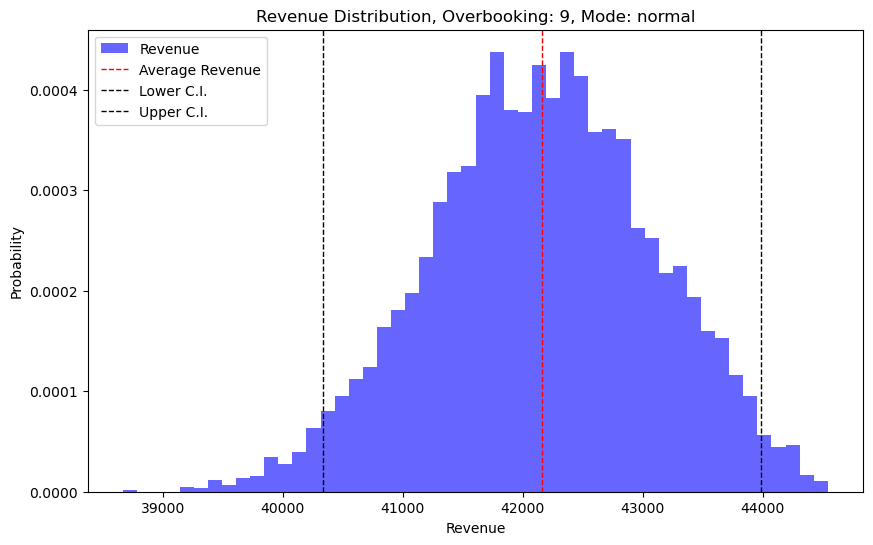

In [71]:
plt.figure(figsize=(10, 6))
plt.hist(profits_list, bins=50, density=True, alpha=0.6, color='blue', label='Revenue')
plt.axvline(average_profit, color='red', linestyle='dashed', linewidth=1, label='Average Revenue')
plt.axvline(average_profit - 1.96*std_profit, color='black', linestyle='dashed', linewidth=1, label='Lower C.I.')
plt.axvline(average_profit + 1.96*std_profit, color='black', linestyle='dashed', linewidth=1, label='Upper C.I.')
plt.title('Revenue Distribution, Overbooking: 9, Mode: normal')
plt.xlabel('Revenue')
plt.ylabel('Probability')
plt.legend()
plt.show()

/var/folders/c8/_5vt7mmd1jdc4_5fbp7135940000gn/T/ipykernel_75411/3912448030.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(profits_list, shade=True)


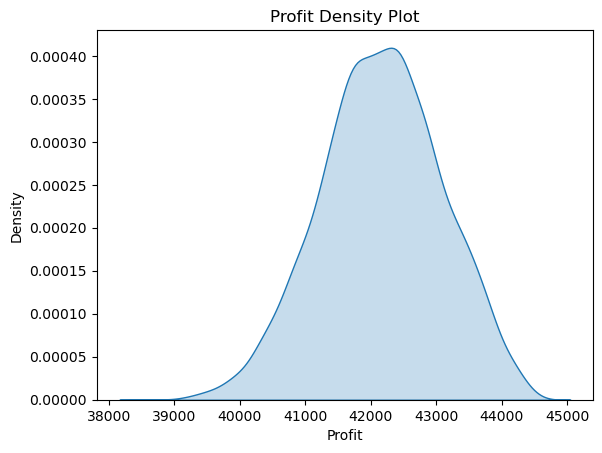

In [72]:
sns.kdeplot(profits_list, shade=True)
plt.title('Profit Density Plot')
plt.xlabel('Profit')
plt.ylabel('Density')
plt.show()

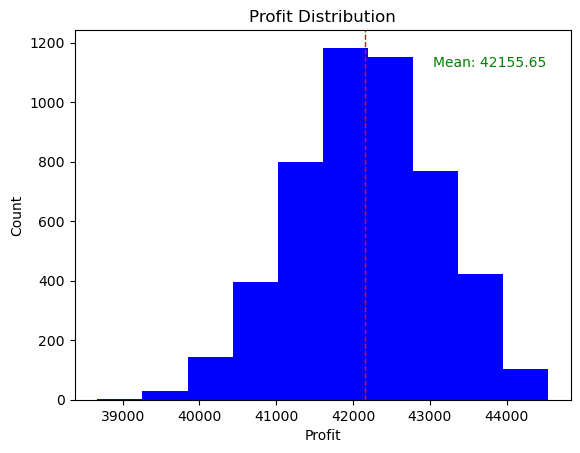

In [73]:
plt.hist(profits_list, color='b')  
plt.axvline(np.array(profits_list).mean(), color='r', linestyle='dashed', linewidth=1)  # Changing axvline color to red
min_ylim, max_ylim = plt.ylim()
min_xlim, max_xlim = plt.xlim()
plt.text(max_xlim*0.96, max_ylim*0.9, 'Mean: {:.2f}'.format(np.array(profits_list).mean()), color='g')  # Changing text color to green
plt.title('Profit Distribution')
plt.xlabel('Profit')
plt.ylabel('Count')
plt.show()


<div style="background-color: #e0ffff; color: black; padding: 10px;">
<p>

- The dashed red line indicates the mean of the distribution, which is labeled as approximately 42,155.65. This value represents the average profit across all observations.
- The distribution appears to be roughly symmetric with a slight right skew, as the right tail seems to extend further out than the left tail. This suggests that there are a few profit values that are significantly higher than the mean.
- The profits span from under 39,000 to over 44,000. There's a noticeable concentration of values around the mean, and the counts taper off as the profits increase or decrease from the mean.


Overall, the histogram suggests a relatively normal distribution of profits with a mean value of around 42,155.65, with most profit values not far from this mean, indicating a relatively stable and consistent profitability.</p>
</div>

# Assessing the strategy of overbooking 20 coach seats with the provision to forgo sales if it proves more profitable

In [74]:
extra_modified = {'coach':20,'first-class':0}
U_modified_optimal,V_modified_optimal = modified_tickets_price_optimizer(capacity,extra_modified,costs,price,prob,delta,T)

In [112]:
profits_list_mod = []
tc_list_mod = []
tf_list_mod = []
tc_act_list_mod = []
tf_act_list_mod = []
ctoout_count_list_mod = []
cost_list_mod = []
np.random.seed(10)
for sim in range(nsim):
    tc,tf,tc_act, tf_act,profit,ctoout_count,cost = profit_simulation(U_modified_optimal,V_modified_optimal,20)
    profits_list_mod.append(profit)
    tc_list_mod.append(tc)
    tf_list_mod.append(tf)
    tc_act_list_mod.append(tc_act)
    tf_act_list_mod.append(tf_act)
    ctoout_count_list_mod.append(ctoout_count)
    cost_list_mod.append(cost)
average_profit_mod = np.array(profits_list_mod).mean()
std_profit_mod = np.array(profits_list_mod).std()
print('Average discounted profit when we decide to have 20 coach tickets to be overbooked with the option of not selling:',average_profit_mod)
print('Standard deviation of discounted profit when we decide to have 9 coach tickets to be overbooked:',std_profit_mod)

Average discounted profit when we decide to have 20 coach tickets to be overbooked with the option of not selling: 42149.15634057132
Standard deviation of discounted profit when we decide to have 9 coach tickets to be overbooked: 929.308313925256


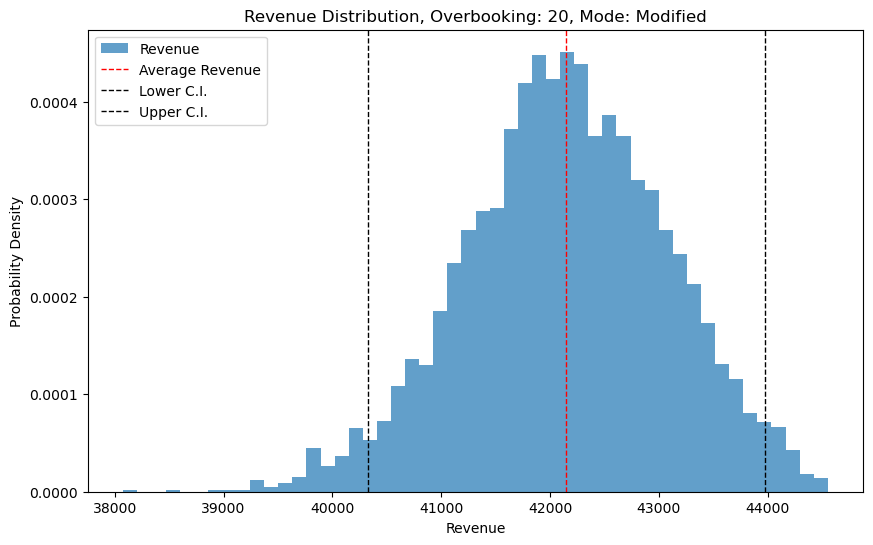

In [78]:
# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(profits_list_mod, bins=50, density=True, alpha=0.7, label='Revenue')
plt.axvline(average_profit_mod, color='red', linestyle='dashed', linewidth=1, label='Average Revenue')
# Confidence interval lines assuming a normal distribution for visualization purposes
plt.axvline(average_profit_mod - 1.96 * std_profit_mod, color='black', linestyle='dashed', linewidth=1, label='Lower C.I.')
plt.axvline(average_profit_mod + 1.96 * std_profit_mod, color='black', linestyle='dashed', linewidth=1, label='Upper C.I.')
plt.title('Revenue Distribution, Overbooking: 20, Mode: Modified')
plt.xlabel('Revenue')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

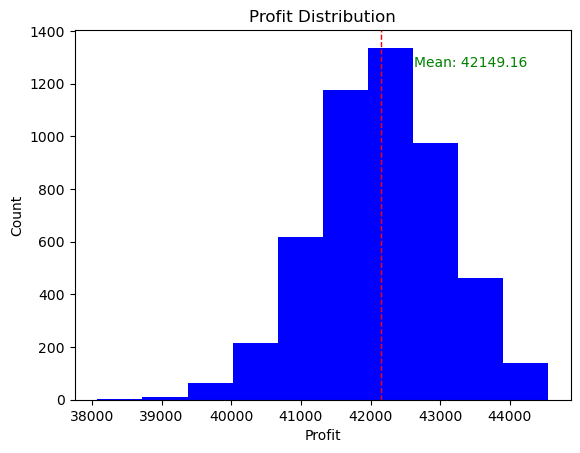

In [71]:
plt.hist(profits_list_mod,color='b')
plt.axvline(np.array(profits_list_mod).mean(), color='r', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
min_xlim, max_xlim = plt.xlim()
plt.text(max_xlim*0.95, max_ylim*0.9, 'Mean: {:.2f}'.format(np.array(profits_list_mod).mean()),color='g')
plt.title('Profit Distribution')
plt.xlabel('Profit')
plt.ylabel('Count')
plt.show()

<div style="background-color: #e0ffff; color: black; padding: 10px;">
<p>
This histogram visualizes the distribution of profits, with a mean profit value marked at approximately 42,149.16. The data spans from around 38,000 to 44,000, with the highest frequency of profit values clustered just below the mean. The shape of the distribution appears to be roughly symmetric around the mean, although there is a noticeable left skew, given that the left side of the histogram (profits less than the mean) extends further than the right side. This suggests that while many profit occurrences are close to the mean value, there are relatively more instances of lower profits than there are of significantly higher profits. The overall distribution suggests variability in profit outcomes, with a central tendency that's a bit lower than the middle of the profit range.</p>
    
</div>

# COMPARISIONS

**Revenue Distribution Comparisions**

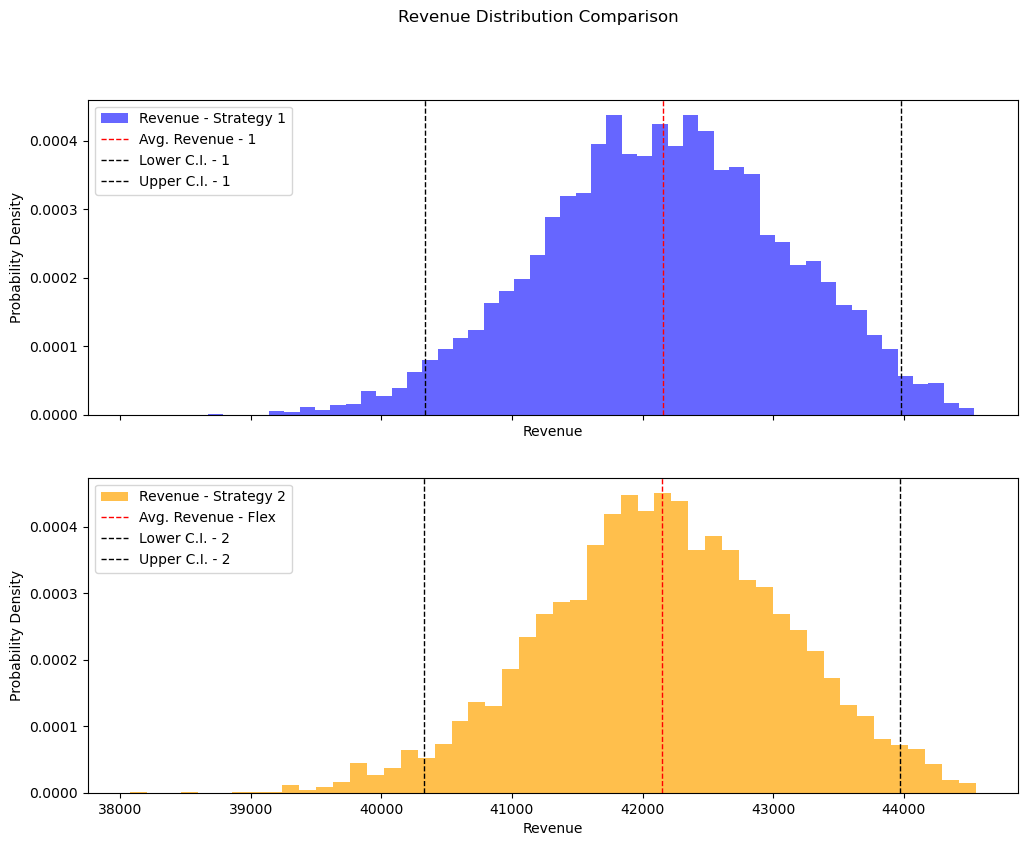

In [105]:
average_profit = np.mean(profits_list)
std_profit = np.std(profits_list)
average_profit_mod = np.mean(profits_list_mod)
std_profit_mod = np.std(profits_list_mod)

# Set up the matplotlib figure
fig, axs = plt.subplots(2, 1, figsize=(12, 9), sharex=True)

# Original scenario
axs[0].hist(profits_list, bins=50, density=True, alpha=0.6, color='blue', label='Revenue - Strategy 1')
axs[0].axvline(average_profit, color='red', linestyle='dashed', linewidth=1, label='Avg. Revenue - 1')
axs[0].axvline(average_profit - 1.96*std_profit, color='black', linestyle='dashed', linewidth=1, label='Lower C.I. - 1')
axs[0].axvline(average_profit + 1.96*std_profit, color='black', linestyle='dashed', linewidth=1, label='Upper C.I. - 1')

# Modified scenario
axs[1].hist(profits_list_mod, bins=50, density=True, alpha=0.7, color='orange', label='Revenue - Strategy 2')
axs[1].axvline(average_profit_mod, color='red', linestyle='dashed', linewidth=1, label='Avg. Revenue - Flex')
axs[1].axvline(average_profit_mod - 1.96 * std_profit_mod, color='black', linestyle='dashed', linewidth=1, label='Lower C.I. - 2')
axs[1].axvline(average_profit_mod + 1.96 * std_profit_mod, color='black', linestyle='dashed', linewidth=1, label='Upper C.I. - 2')

# Set common labels
for ax in axs:
    ax.set_xlabel('Revenue')
    ax.set_ylabel('Probability Density')
    ax.legend()

plt.suptitle('Revenue Distribution Comparison')
plt.show()

**Overbooking Cost Distribution**

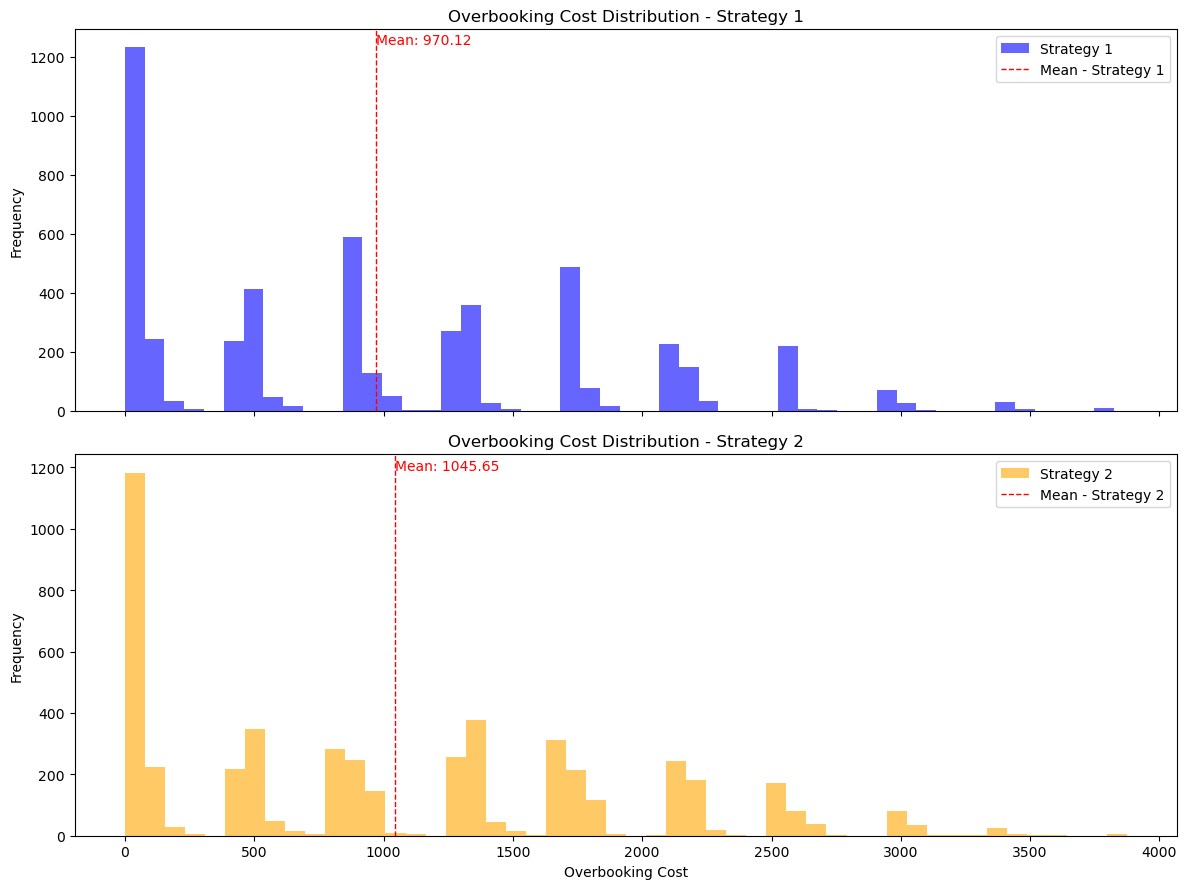

In [106]:
# Calculate the means
mean_cost_original = np.mean(cost_list)
mean_cost_modified = np.mean(cost_list_mod)

# Set up the matplotlib figure and axes
fig, axs = plt.subplots(2, 1, figsize=(12, 9), sharex=True)

# Original overbooking cost distribution plot
n_original, bins_original, patches_original = axs[0].hist(cost_list, bins=50, color='blue', alpha=0.6, label='Strategy 1')
axs[0].axvline(mean_cost_original, color='red', linestyle='dashed', linewidth=1, label='Mean - Strategy 1')
axs[0].text(mean_cost_original, max(n_original), f'Mean: {mean_cost_original:.2f}', color='red', verticalalignment='bottom')
axs[0].set_title('Overbooking Cost Distribution - Strategy 1')
axs[0].set_ylabel('Frequency')
axs[0].legend()

# Modified overbooking cost distribution plot
n_modified, bins_modified, patches_modified = axs[1].hist(cost_list_mod, bins=50, color='orange', alpha=0.6, label='Strategy 2')
axs[1].axvline(mean_cost_modified, color='red', linestyle='dashed', linewidth=1, label='Mean - Strategy 2')
axs[1].text(mean_cost_modified, max(n_modified), f'Mean: {mean_cost_modified:.2f}', color='red', verticalalignment='bottom')
axs[1].set_title('Overbooking Cost Distribution - Strategy 2')
axs[1].set_xlabel('Overbooking Cost')
axs[1].set_ylabel('Frequency')
axs[1].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

**Coach Seats Booked Distribution**

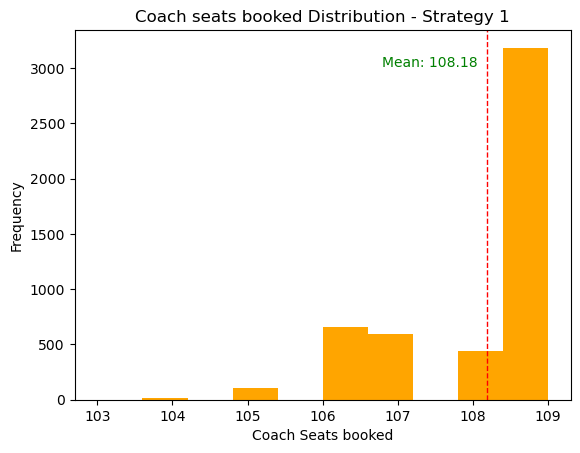

The coach is always overbooked if we have the option.


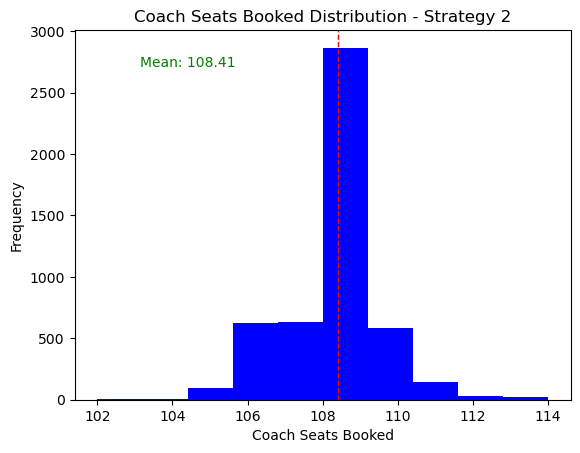

The number of coach seats booked is rarely higher than 109 as that is point where we get the highest expected profit.


In [145]:
plt.hist(tc_list, color = 'orange')
plt.axvline(np.array(tc_list).mean(), color='r', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
min_xlim, max_xlim = plt.xlim()
plt.text(max_xlim*0.977, max_ylim*0.9, 'Mean: {:.2f}'.format(np.array(tc_list).mean()),color = 'g')
plt.title('Coach seats booked Distribution - Strategy 1')
plt.xlabel('Coach Seats booked')
plt.ylabel('Frequency')
plt.show()

print("The coach is always overbooked if we have the option.")

plt.hist(tc_list_mod,color='b')
plt.axvline(np.array(tc_list_mod).mean(), color='r', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
min_xlim, max_xlim = plt.xlim()
plt.text(max_xlim*0.90, max_ylim*0.9, 'Mean: {:.2f}'.format(np.array(tc_list_mod).mean()),color='g')
plt.title('Coach Seats Booked Distribution - Strategy 2')
plt.xlabel('Coach Seats Booked')
plt.ylabel('Frequency')
plt.show()

print("The number of coach seats booked is rarely higher than 109 as that is point where we get the highest expected profit.")

**First-Class Seats Booked Distribution**

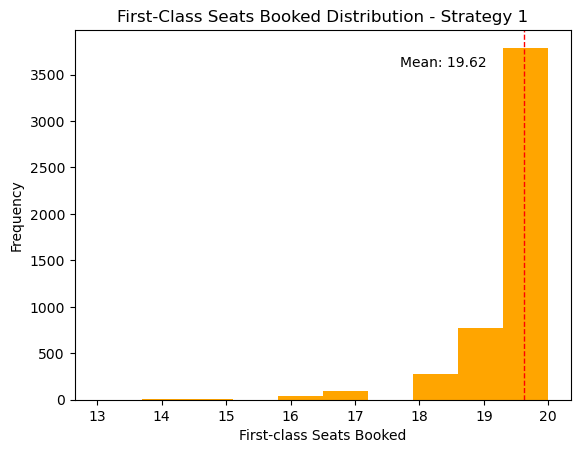

Even if it looks like the probability of selling a first-class ticket is low, it mostly gets fully booked due to the higher number of days to book them than the number of first-class tickets.


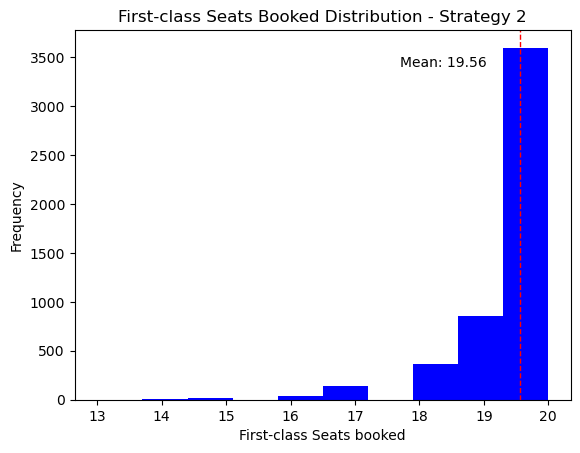

The frequent full booking of first-class seats is largely attributable to the greater window of time available for booking compared to the limited number of first-class tickets on offer.


In [147]:
plt.hist(tf_list,color='orange')
plt.axvline(np.array(tf_list).mean(), color='red', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
min_xlim, max_xlim = plt.xlim()
plt.text(max_xlim*0.87, max_ylim*0.9, 'Mean: {:.2f}'.format(np.array(tf_list).mean()))
plt.title('First-Class Seats Booked Distribution - Strategy 1')
plt.xlabel('First-class Seats Booked')
plt.ylabel('Frequency')
plt.show()

print("Even if it looks like the probability of selling a first-class ticket is low, it mostly gets fully booked due to the higher number of days to book them than the number of first-class tickets.")


plt.hist(tf_list_mod,color='blue')
plt.axvline(np.array(tf_list_mod).mean(), color='red', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
min_xlim, max_xlim = plt.xlim()
plt.text(max_xlim*0.87, max_ylim*0.9, 'Mean: {:.2f}'.format(np.array(tf_list_mod).mean()))
plt.title('First-class Seats Booked Distribution - Strategy 2')
plt.xlabel('First-class Seats booked')
plt.ylabel('Frequency')
plt.show()

print("The frequent full booking of first-class seats is largely attributable to the greater window of time available for booking compared to the limited number of first-class tickets on offer.")


**Distribution of Actual Coach Passengers Showing up during Departure**

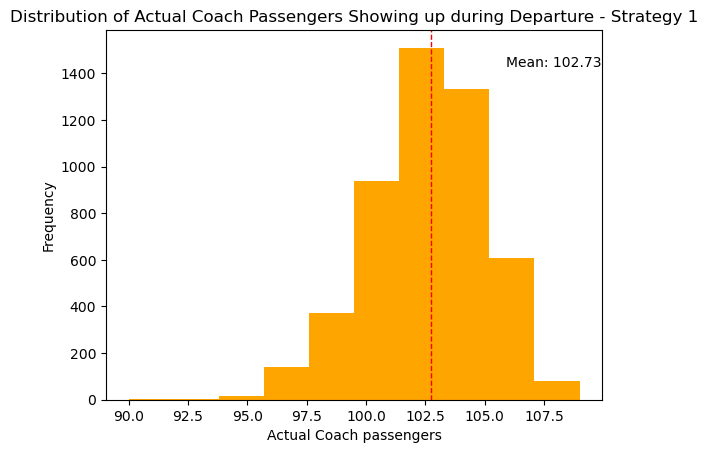

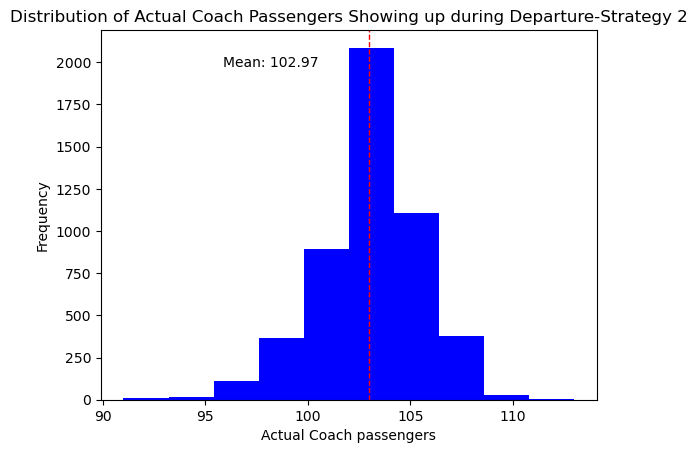

In [148]:
plt.hist(tc_act_list,color='orange')
plt.axvline(np.array(tc_act_list).mean(), color='red', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
min_xlim, max_xlim = plt.xlim()
plt.text(max_xlim*0.963, max_ylim*0.9, 'Mean: {:.2f}'.format(np.array(tc_act_list).mean()))
plt.title('Distribution of Actual Coach Passengers Showing up during Departure - Strategy 1')
plt.xlabel('Actual Coach passengers')
plt.ylabel('Frequency')
plt.show()

plt.hist(tc_act_list_mod,color='blue')
plt.axvline(np.array(tc_act_list_mod).mean(), color='red', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
min_xlim, max_xlim = plt.xlim()
plt.text(max_xlim*0.84, max_ylim*0.9, 'Mean: {:.2f}'.format(np.array(tc_act_list_mod).mean()))
plt.title('Distribution of Actual Coach Passengers Showing up during Departure-Strategy 2')
plt.xlabel('Actual Coach passengers')
plt.ylabel('Frequency')
plt.show()

**Distribution of Actual First-class Passengers Showing up during Departure**

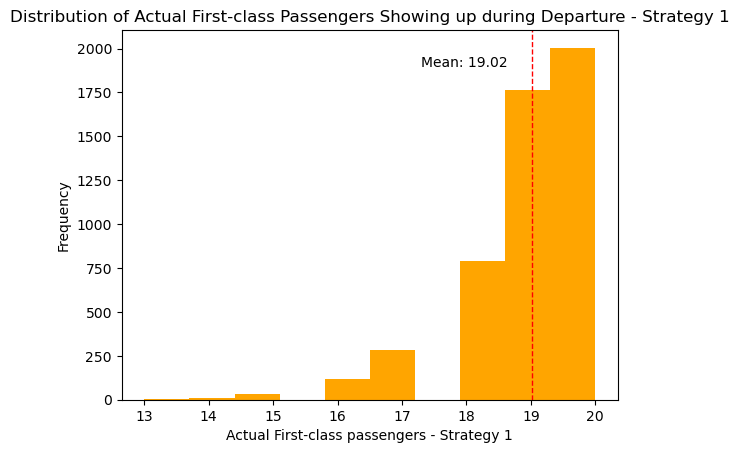

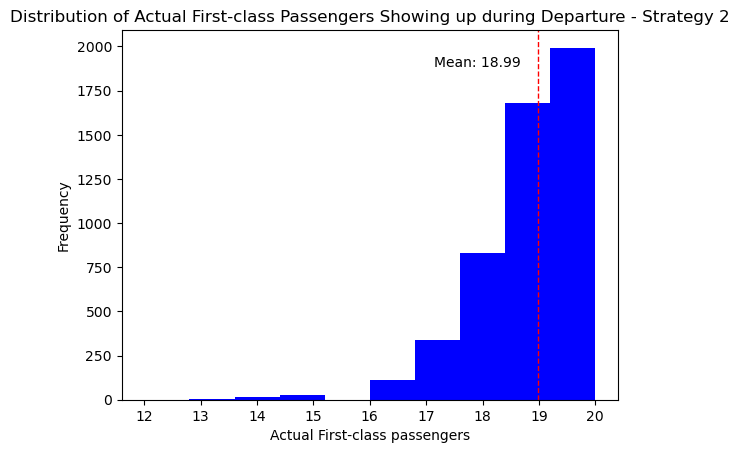

In [149]:
plt.hist(tf_act_list,color='orange')
plt.axvline(np.array(tf_act_list).mean(), color='red', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
min_xlim, max_xlim = plt.xlim()
plt.text(max_xlim*0.85, max_ylim*0.9, 'Mean: {:.2f}'.format(np.array(tf_act_list).mean()))
plt.title('Distribution of Actual First-class Passengers Showing up during Departure - Strategy 1')
plt.xlabel('Actual First-class passengers - Strategy 1')
plt.ylabel('Frequency')
plt.show()

plt.hist(tf_act_list_mod,color='blue')
plt.axvline(np.array(tf_act_list_mod).mean(), color='red', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
min_xlim, max_xlim = plt.xlim()
plt.text(max_xlim*0.84, max_ylim*0.9, 'Mean: {:.2f}'.format(np.array(tf_act_list_mod).mean()))
plt.title('Distribution of Actual First-class Passengers Showing up during Departure - Strategy 2')
plt.xlabel('Actual First-class passengers')
plt.ylabel('Frequency')
plt.show()

**Distribution of Passengers Kicked Off the Plane**

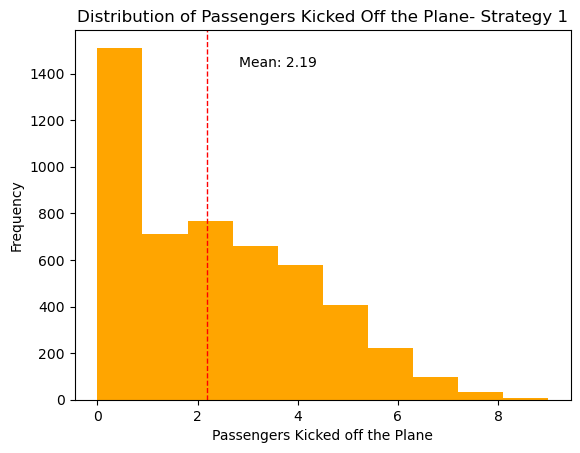

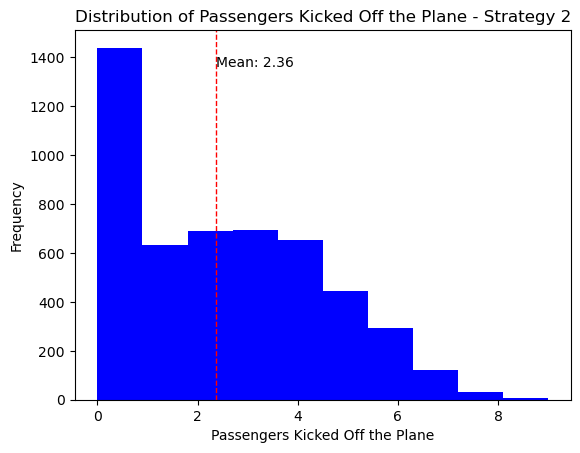

In [150]:
plt.hist(ctoout_count_list,color='orange')
plt.axvline(np.array(ctoout_count_list).mean(), color='red', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
min_xlim, max_xlim = plt.xlim()
plt.text(max_xlim*0.30, max_ylim*0.9, 'Mean: {:.2f}'.format(np.array(ctoout_count_list).mean()))
plt.title('Distribution of Passengers Kicked Off the Plane- Strategy 1')
plt.xlabel('Passengers Kicked off the Plane')
plt.ylabel('Frequency')
plt.show()

plt.hist(ctoout_count_list_mod,color='blue')
plt.axvline(np.array(ctoout_count_list_mod).mean(), color='red', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
min_xlim, max_xlim = plt.xlim()
plt.text(max_xlim*0.25, max_ylim*0.9, 'Mean: {:.2f}'.format(np.array(ctoout_count_list_mod).mean()))
plt.title('Distribution of Passengers Kicked Off the Plane - Strategy 2')
plt.xlabel('Passengers Kicked Off the Plane')
plt.ylabel('Frequency')
plt.show()

In [140]:
print("Strategy 1 - Among 5000 simulations, there were " + str(ctoout_count_list.count(0)) + " instances where no passenger was kicked off the plane. However, despite this relatively high occurrence, the instances where at least one passenger was kicked off the plane were more frequent, totaling " + str(5000 - ctoout_count_list.count(0)))

Strategy 1 - Among 5000 simulations, there were 1511 instances where no passenger was kicked off the plane. However, despite this relatively high occurrence, the instances where at least one passenger was kicked off the plane were more frequent, totaling 3489


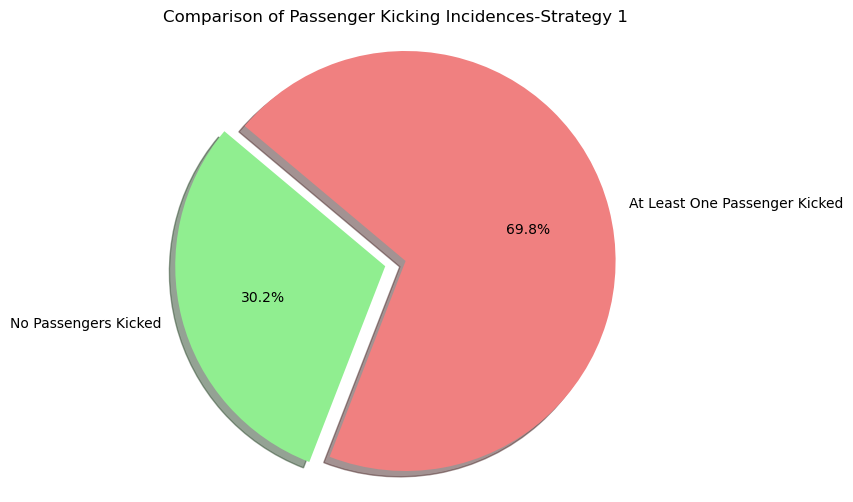

In [142]:
import matplotlib.pyplot as plt

# Replace these counts with the actual counts from your simulation data
no_kick_count = 1511
kick_count = 3489

# Data to plot
labels = 'No Passengers Kicked', 'At Least One Passenger Kicked'
sizes = [no_kick_count, kick_count]
colors = ['lightgreen', 'lightcoral']
explode = (0.1, 0)  # explode the first slice

# Plot
plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Comparison of Passenger Kicking Incidences-Strategy 1')
plt.show()

In [143]:
print(f'Strategy 2- Out of 5000 flights, there are {ctoout_count_list_mod.count(0)} cases where no passengers are removed from the plane. '
      f'Despite this substantial figure, the occurrences where at least one passenger is displaced are more common, numbering {5000 - ctoout_count_list_mod.count(0)}.')


Strategy 2- Out of 5000 flights, there are 1439 cases where no passengers are removed from the plane. Despite this substantial figure, the occurrences where at least one passenger is displaced are more common, numbering 3561.


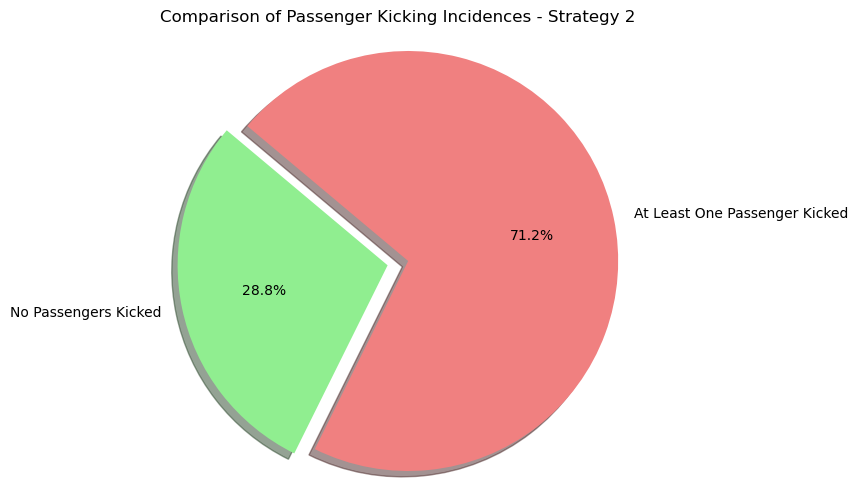

In [144]:
import matplotlib.pyplot as plt

# Replace these counts with the actual counts from your simulation data
no_kick_count = 1439
kick_count = 3561

# Data to plot
labels = 'No Passengers Kicked', 'At Least One Passenger Kicked'
sizes = [no_kick_count, kick_count]
colors = ['lightgreen', 'lightcoral']
explode = (0.1, 0)  # explode the first slice

# Plot
plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Comparison of Passenger Kicking Incidences - Strategy 2')
plt.show()
